In [1]:
import time
# import IPython
import os
import json
from datetime import datetime
import pyswarm
import pandas

import joblib
import numpy as np
import matplotlib.pyplot as plt
# from mpl_toolkits.mplot3d import Axes3D
import tensorflow.compat.v2 as tf
import tensorflow_probability as tfp
from tensorflow import keras
import tensorflow.keras.backend as K


from keras.models import Sequential, Model
# from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization, Lambda, Layer
# from tensorflow.keras import losses
# from keras.utils.vis_utils import plot_model, model_to_dot

from sklearn.preprocessing import StandardScaler, MinMaxScaler
import sklearn.preprocessing

# from sklearn.model_selection import train_test_split
# from sklearn.metrics import r2_score, mean_absolute_error, median_absolute_error

K.set_floatx('float32')

tfb = tfp.bijectors
tfd = tfp.distributions
tfk = tfp.math.psd_kernels

tf.enable_v2_behavior()

from tester.tester import Tester

2022-01-27 23:22:33.828007: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-01-27 23:22:33.828052: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
log_path = os.path.join('.','2022_01_25_16_18_38')
log_path

'./2022_01_25_16_18_38'

In [3]:
path = os.path.join(log_path, 'run_stats.txt')
with open(path, 'r') as file:
    run_stats = json.load(file)    

    
num_samples = run_stats['num_samples']
training_proportion = run_stats['training_proportion']
optimization_proportion = 1. - training_proportion

log_std_coefficient = run_stats['log_std_coefficient']
constant_std_coefficient = run_stats['constant_std_coefficient']

run_stats

{'num_samples': 90,
 'training_proportion': 0.4,
 'log_std_coefficient': 4.0,
 'constant_std_coefficient': 20.0}

In [4]:
path = os.path.join(log_path, 'training.npyz')
with open(path, 'rb') as file:
    training_data = np.load(file)
    training_Xs=training_data['points']
    training_ys=training_data['values']
    norm_training_Xs=training_data['norm_points']
    norm_training_ys=training_data['norm_values']
    lls_=training_data['loss']
    amplitude= training_data['amplitude']
    relevances= training_data['relevances']
    noise_var= training_data['noise']
    

In [5]:
path=os.path.join(log_path,'scaler_X.pkl')
transform_X = joblib.load(path)
path=os.path.join(log_path,'scaler_y.pkl')
transform_y = joblib.load(path)


/home/llarrauriborroto/Documents/Projects/advanced-bayesian-opt/lib/python3.8/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.preprocessing.data module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.preprocessing. Anything that cannot be imported from sklearn.preprocessing is now part of the private API.
  warnings.warn(message, FutureWarning)
/home/llarrauriborroto/Documents/Projects/advanced-bayesian-opt/lib/python3.8/site-packages/sklearn/base.py:313: UserWarning: Trying to unpickle estimator StandardScaler from version 0.21.2 when using version 0.22. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(


In [6]:
norm_training_Xs


array([[ 0.55797064,  0.31779677,  1.1263825 ],
       [-1.001019  ,  1.3053043 ,  0.22233792],
       [-1.7105443 ,  1.4120718 , -0.55171585],
       [-0.6617521 ,  0.70769274,  0.05363295],
       [-0.4698539 ,  0.83693504,  0.42663938],
       [ 0.80659527, -1.1029892 , -0.840106  ],
       [ 0.6253257 , -0.04667268,  1.0358412 ],
       [ 1.207303  , -1.167522  ,  1.2467434 ],
       [-1.0687643 , -0.99639845,  0.54136467],
       [ 1.4328182 ,  0.39274195,  0.7311128 ],
       [ 1.367053  , -1.079461  , -0.92183006],
       [-0.45309997, -1.8652222 , -0.3337384 ],
       [ 0.11859892,  1.3005259 , -0.2365356 ],
       [-0.06587341,  0.36932373,  1.7108797 ],
       [-0.6962158 ,  0.529022  , -0.7303287 ],
       [ 1.2756422 ,  1.2267271 ,  0.548449  ],
       [-1.7271004 ,  0.34880668, -0.37390026],
       [ 1.1472366 , -1.3975664 , -0.04322033],
       [ 0.38927355,  0.7756967 ,  0.1167587 ],
       [ 0.06283772,  0.53170174, -0.13137032],
       [ 0.61982626, -1.8264227 ,  0.948

In [7]:
kernel = tfk.ExponentiatedQuadratic(amplitude, length_scale=1.0)
kernel = tfk.FeatureScaled(kernel, scale_diag=relevances)
gp_model = tfd.GaussianProcessRegressionModel(
    kernel=kernel,
    index_points=[[1.2353002 , -0.7703848 ,  1.1779659]],
    observation_index_points=norm_training_Xs,
    observations=norm_training_ys,
    observation_noise_variance=noise_var,
    predictive_noise_variance=0.,
    jitter=1e-4)

gp_model.mean()

2022-01-27 23:22:36.756755: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-01-27 23:22:36.756796: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-01-27 23:22:36.756826: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (t460slalb): /proc/driver/nvidia/version does not exist
2022-01-27 23:22:36.757446: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


<tf.Tensor: shape=(), dtype=float32, numpy=-1.0450783>

In [8]:
path = os.path.join(log_path, 'optimization_rounds.npyz')
with open(path, 'rb') as file:
    optimization_data = np.load(file)
    real_values=optimization_data['values']
    real_choices=optimization_data['choices']
    mean_regrets=optimization_data['mean_regrets']


In [9]:
values= transform_y.transform(real_values.reshape(-1,1))
choices= np.array(transform_X.transform(real_choices), dtype=np.float32)
values=np.array(values.flatten(),dtype=np.float32)


In [10]:
with open('./validation_samples.csv', newline='') as csvfile:
    reader = pandas.read_csv(csvfile,delimiter=';')

    

In [11]:
real_values

array([1.1358907, 1.1365881, 1.1364679, 1.1355258, 1.135202 , 1.1354039,
       1.1359833, 1.1358706, 1.1354722, 1.1355873, 1.1356149, 1.136067 ,
       1.1355072, 1.135894 , 1.1368655, 1.1367347, 1.1360666, 1.1356366,
       1.1351925, 1.1363605, 1.1361253, 1.1356137, 1.1359258, 1.1361856,
       1.1357933, 1.1364375, 1.1369287, 1.136221 , 1.1353245, 1.1357185,
       1.1361742, 1.1368291, 1.1358026, 1.1352822, 1.1361651, 1.1363196,
       1.1363792, 1.1361257, 1.1364133, 1.1364216, 1.1357597, 1.1362729,
       1.1360664, 1.1357936, 1.1357865, 1.1355251, 1.1358663, 1.1368576,
       1.1363742, 1.1364981, 1.1366631, 1.1361525, 1.1355667, 1.1361572],
      dtype=float32)

In [12]:
nom_cols =(reader['corner']=='nom') & (reader['Parameter Label']=='V_ref_1v133_untrimmed')
validation_frame= reader[nom_cols]
validation_frame


,Parameter Label,Pattern,Run,Measurement Name,corner,p_vdda_evr,p_vdda_hpbg,p_vddpd,p_vref,p_vss,temperature,trimbg,trimcur,Unnamed: 13,Value,MC Mean,MC Stddev,Cp,Cpk,Unit
4860,V_ref_1v133_untrimmed,hpbg_startup_trimall2,RUN0001,V_ref_1v133_untrimmed,nom,2.2,2.2,1.08,0.6,0,-40,64,16,NaN,1.136468,,,,,V
4861,V_ref_1v133_untrimmed,hpbg_startup_trimall2,RUN0002,V_ref_1v133_untrimmed,nom,2.2,2.2,1.12,0.6,0,-40,64,16,NaN,1.136453,,,,,V
4862,V_ref_1v133_untrimmed,hpbg_startup_trimall2,RUN0003,V_ref_1v133_untrimmed,nom,2.2,2.2,1.16,0.6,0,-40,64,16,NaN,1.136481,,,,,V
4863,V_ref_1v133_untrimmed,hpbg_startup_trimall2,RUN0004,V_ref_1v133_untrimmed,nom,2.2,2.2,1.20,0.6,0,-40,64,16,NaN,1.136483,,,,,V
4864,V_ref_1v133_untrimmed,hpbg_startup_trimall2,RUN0005,V_ref_1v133_untrimmed,nom,2.2,2.2,1.24,0.6,0,-40,64,16,NaN,1.136455,,,,,V
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5827,V_ref_1v133_untrimmed,hpbg_startup_trimall2,RUN0968,V_ref_1v133_untrimmed,nom,2.8,2.8,1.24,0.6,0,175,64,16,NaN,1.135183,,,,,V
5828,V_ref_1v133_untrimmed,hpbg_startup_trimall2,RUN0969,V_ref_1v133_untrimmed,nom,2.8,2.8,1.28,0.6,0,175,64,16,NaN,1.135178,,,,,V
5829,V_ref_1v133_untrimmed,hpbg_startup_trimall2,RUN0970,V_ref_1v133_untrimmed,nom,2.8,2.8,1.32,0.6,0,175,64,16,NaN,1.135178,,,,,V
5830,V_ref_1v133_untrimmed,hpbg_startup_trimall2,RUN0971,V_ref_1v133_untrimmed,nom,2.8,2.8,1.36,0.6,0,175,64,16,NaN,1.135173,,,,,V


In [13]:
valid_real_ys=[]
valid_real_Xs=[]
for index, row in validation_frame.iterrows():
    valid_real_ys.append(row['Value'])
    valid_real_Xs.append([row['p_vdda_evr'], row['p_vddpd'], row['temperature']])

# print(valid_real_Xs)
valid_norm_Xs=np.array(transform_X.transform(valid_real_Xs),dtype=np.float32)
valid_norm_Xs
print(valid_real_ys)

[1.13646789, 1.13645325, 1.13648089, 1.13648258, 1.13645458, 1.13645301, 1.13647462, 1.13646639, 1.13643748, 1.13661531, 1.1366072, 1.13662177, 1.13661863, 1.13660614, 1.13659826, 1.13662052, 1.1366148, 1.13660531, 1.13674418, 1.13675191, 1.13675407, 1.13674355, 1.1367403, 1.13673621, 1.13675145, 1.13674468, 1.13673833, 1.13686901, 1.13689022, 1.13688788, 1.1368802, 1.13687515, 1.13687654, 1.13688254, 1.13688035, 1.13686748, 1.13691227, 1.13692429, 1.13693071, 1.13691271, 1.13692251, 1.1369193, 1.13691801, 1.13691637, 1.13691038, 1.13694765, 1.13695589, 1.13695127, 1.136933, 1.1369461, 1.13694967, 1.13694559, 1.13694857, 1.13693119, 1.13692468, 1.13691953, 1.13692946, 1.13690486, 1.13692096, 1.13692047, 1.13692173, 1.13691878, 1.13689816, 1.13683329, 1.13683392, 1.13683323, 1.13684512, 1.13683316, 1.13683015, 1.13683802, 1.13683841, 1.1368365, 1.13669924, 1.13670199, 1.13668985, 1.13670191, 1.1366932, 1.13668845, 1.13668786, 1.13668694, 1.13668736, 1.13648463, 1.13650024, 1.13648744, 1

In [14]:
opt_norm_Xs=norm_training_Xs.tolist()
opt_norm_ys=norm_training_ys.tolist()


In [15]:

print(len(norm_training_Xs.tolist()))
print(len(opt_norm_Xs))
print(len(opt_norm_ys))
print(len(choices))
print(len(values))


36
36
36
54
54


In [16]:
errs=[]
smerrs=[]
total_errs=[]

for i in range((len(choices))):
    opt_norm_Xs.append(choices[i])
    opt_norm_ys.append(values[i])

    gp_model = tfd.GaussianProcessRegressionModel(
        kernel=kernel,
        index_points=valid_norm_Xs,
        observation_index_points=opt_norm_Xs,
        observations=opt_norm_ys,
        observation_noise_variance=noise_var,
        predictive_noise_variance=0.,
        jitter=1e-4)
    pred_norm_ys = gp_model.mean().numpy()
    pred_real_ys = transform_y.inverse_transform(pred_norm_ys.reshape(-1,1)).flatten()

    valid_errs = pred_real_ys - valid_real_ys
    total_errs.append(valid_errs)
    errs.append(np.amax(valid_errs))
    sqvalid_errs = np.square(valid_errs)
    smerrs.append(np.sqrt(np.mean(sqvalid_errs)))
    


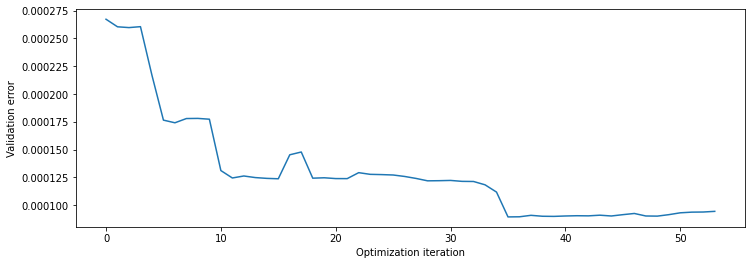

In [17]:
plt.figure(figsize=(12, 4))
plt.plot(errs)
plt.xlabel("Optimization iteration")
plt.ylabel("Validation error")
# path = os.path.join(log_path, 'mean_regrets.png')
# plt.savefig(path)
# plt.show()
plt.savefig('max_loss.pdf',format='pdf',dpi=1200)

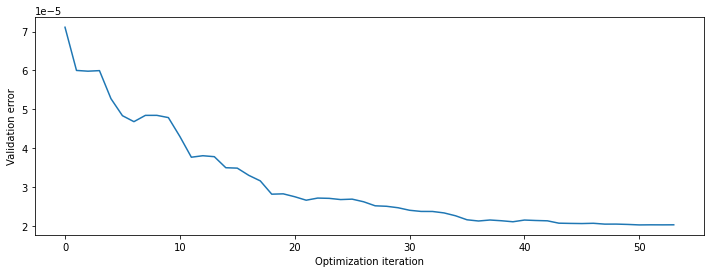

In [18]:
plt.figure(figsize=(12, 4))
plt.plot(smerrs)
plt.xlabel("Optimization iteration")
plt.ylabel("Validation error")
# path = os.path.join(log_path, 'mean_regrets.png')
# plt.savefig(path)
# plt.show()
plt.savefig('sme.pdf',format='pdf',dpi=1200)

In [19]:
total_errs[-1]

array([-1.50606598e-06,  1.19418411e-05, -1.76055075e-05, -2.16796933e-05,
        3.34007446e-06,  1.33379578e-06, -2.44485294e-05, -2.08676917e-05,
        1.48579742e-06,  2.94656891e-06,  1.14141968e-05, -3.51343109e-06,
       -1.32710541e-06,  9.25554596e-06,  1.46321509e-05, -1.09657092e-05,
       -9.17961578e-06, -5.76928955e-06,  9.15252991e-07, -4.90739838e-06,
       -5.99451477e-06,  4.64469452e-06,  7.29864807e-06,  9.83892731e-06,
       -7.90446777e-06, -4.35311859e-06, -3.24832733e-06,  2.56630920e-06,
       -1.56634586e-05, -1.11776913e-05, -2.42480774e-06,  2.74440155e-06,
        4.00727234e-07, -7.38741211e-06, -7.93922577e-06,  4.31933593e-08,
       -6.39369507e-07, -9.55992798e-06, -1.38341608e-05,  5.35793213e-06,
       -4.44206787e-06, -2.18574219e-06, -2.80309082e-06, -4.02411377e-06,
       -3.16011322e-06, -6.33625641e-06, -1.18344427e-05, -5.42630341e-06,
        1.35589523e-05,  2.20533752e-07, -4.77997772e-06, -3.08416351e-06,
       -9.40202362e-06,  